In [2]:
import numpy as np
import os
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, TimeDistributed
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from keras.layers import Input, Dense
from keras.models import Model
%matplotlib inline
import pandas as pd
from keras.models import Sequential

from utils import *

Using TensorFlow backend.


#### Get data

In [2]:
fpaths = []
labels = []
word_spoken = []


dataset = '41'
input_folder = 'data\{}'.format(dataset)

# pars the input directory that contains audio files
# get audio files and their lables

for f in os.listdir(input_folder):
    for w in os.listdir(input_folder+'\\'+ f):
        # check wheter files is wav or not
        
        if (w.find('wav')!=-1):
            fpaths.append(input_folder+'\\'+f+'\\'+w)
            labels.append(f)
            if f not in word_spoken:
                word_spoken.append(f)
print("Spoken words: "+ str(word_spoken))

Spoken words: ['0_zero', '1_one', '2_two', '3_three', '4_four', '5_five', '6_six', '7_seven', '8_eight', '9_nine', 'aboard', 'adjusted & locked', 'All switches', 'Alternate air door', 'A_C Documents', 'Battery+Main bus', 'Cabin doors', 'Checked', 'Circuit Breakers', 'Closed', 'Cockpit', 'Cockpit checklist completed', 'Completed', 'decimal', 'Flight Controls', 'Fuel Quantity', 'Fuel Selector', 'Fuel Shutoff Valve', 'Fuel Temperature', 'in', 'locked', 'off', 'On', 'open', 'preflight_inspection', 'removed', 'Seats & Belts', 'Shut-off cabin heat', 'sufficient', 'Towbar', 'Weight and balance']


In [3]:
# size of dataset
print(len(labels))

21433


## Extracting frequeny domain features

At the second stage we convet a signal into the freqency domain. In monst modern speech recognitoon freqeency-domain features are used as key component. In case of multispeakers MFFC feature extraction works best. After convert a signal into a freq domain, it's requered to convert it into a useable form. **Mel Frequency Cepstral Coefficients (MFCC)** is a good way to do that. *MFCC* takes the power spectrum of a signal and then uses a combination of filter banks and disrete cosinetransform to extract pattern of phones or features.

After extracting **MFFC** features we exract data into single data matrix, and a label vector with the correct label for eac data file is ceated. 

In [66]:
from scipy.io import wavfile

data = []

mfcc_max_length = 0
mfcc_min_length = 1000000
sum_mfcc_features = 0

# first file desitination name and index
file_name = ''
word_spoken_index = 0

for n,file in enumerate(fpaths):
    
    # show current desintation 
    if (file.find(file_name)<=0):
        file_name=word_spoken[word_spoken_index]
        print(word_spoken[word_spoken_index])
        word_spoken_index+=1

    # read file 
    sampling_freq, audio = wavfile.read(file)
    # Extract MFCC features
    mfcc_features = mfcc(audio, sampling_freq)

    
    mfcc_len=mfcc_features.shape[0]*mfcc_features.shape[1]
    # get length of largets feature array
    if mfcc_len>mfcc_max_length:    
        mfcc_max_length=mfcc_len
    if mfcc_len<mfcc_min_length:
        mfcc_min_length=mfcc_len
        
    sum_mfcc_features+=mfcc_len
     
    # flat data into 2D array
    mfcc_features=np.resize(mfcc_features,(1,mfcc_len))
    
    data.insert(n,mfcc_features)
    
median_mfcc=int(sum_mfcc_features/len(data))

0_zero
1_one
2_two
3_three
4_four
5_five
6_six
7_seven
8_eight
9_nine
aboard
adjusted & locked
All switches
Alternate air door
A_C Documents
Battery+Main bus
Cabin doors
Checked
Circuit Breakers
Closed
Cockpit
Cockpit checklist completed
Completed
decimal
Flight Controls
Fuel Quantity
Fuel Selector
Fuel Shutoff Valve
Fuel Temperature
in
locked
off
On
open
preflight_inspection
removed
Seats & Belts
Shut-off cabin heat
sufficient
Towbar
Weight and balance


In [4]:
from scipy.io import wavfile

data = []

# first file desitination name and index
file_name = '';
word_spoken_index = 0;

for n,file in enumerate(fpaths):
    
    # show current desintation 
    if (file.find(file_name)<=0):
        file_name=word_spoken[word_spoken_index]
        print(word_spoken[word_spoken_index])
        word_spoken_index+=1

    # read file 
    sampling_freq, audio = wavfile.read(file)
    # Extract MFCC features
    mfcc_features = mfcc(audio, sampling_freq)
    data.insert(n,mfcc_features)


0_zero
1_one
2_two
3_three
4_four
5_five
6_six
7_seven
8_eight
9_nine
aboard
adjusted & locked
All switches
Alternate air door
A_C Documents
Battery+Main bus
Cabin doors
Checked
Circuit Breakers
Closed
Cockpit
Cockpit checklist completed
Completed
decimal
Flight Controls
Fuel Quantity
Fuel Selector
Fuel Shutoff Valve
Fuel Temperature
in
locked
off
On
open
preflight_inspection
removed
Seats & Belts
Shut-off cabin heat
sufficient
Towbar
Weight and balance


In [32]:
#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', len(data))
all_labels = np.zeros(len(data),dtype=int)
for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
print('Labels and label indices', all_labels)

Number of files total: 21433
Labels and label indices [33 33 33 ... 15 15 15]


In [1]:
target = np.zeros((len(all_labels),41),dtype=int)
for i,_ in enumerate(all_labels):
    target[i][_]=1

NameError: name 'np' is not defined

In [34]:
# get unique labesl
unique_words = set(all_labels)
print(unique_words)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40}


In [153]:
x_data=np.array(data)
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

for train_index, test_index in sss.split(x_data,target):
    X_train, X_test = x_data[train_index], x_data[test_index]
    Y_train, Y_test = target[train_index], target[test_index]
    

print('Size of training matrix:', X_train.shape)
print('Size of testing matrix:', X_test.shape)

Size of training matrix: (18218,)
Size of testing matrix: (3215,)


In [190]:
model = Sequential()


model.add(LSTM(200, return_sequences=True, input_shape=(None, 13)))
model.add(LSTM(200, return_sequences=True))

model.add(TimeDistributed(Dense(200, activation='relu')))

model.add(Dense(41, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [191]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, None, 200)         171200    
_________________________________________________________________
lstm_50 (LSTM)               (None, None, 200)         320800    
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 200)         40200     
_________________________________________________________________
dense_38 (Dense)             (None, None, 41)          8241      
Total params: 540,441
Trainable params: 540,441
Non-trainable params: 0
_________________________________________________________________


In [192]:
from keras.utils import to_categorical
def train_generator():
    for i,_ in enumerate(X_train):
        sequence_length = X_train[i].shape[0]
        x_train = np.random.random((1, sequence_length, 13))
        y_train = np.random.random((1, 1, 41))
        # y_train will depend on past 5 timesteps of x
        x_train[0]=X_train[i]
        y_train[0]=Y_train[i]
        yield x_train, y_train

In [193]:
model.fit_generator(train_generator(), steps_per_epoch=70, epochs=150, verbose=1)

Epoch 1/150
70/70 [==============================] - 21s 306ms/step - loss: 3.6472 - acc: 0.0857
Epoch 2/150
70/70 [==============================] - 17s 245ms/step - loss: 3.4861 - acc: 0.0915
Epoch 3/150
70/70 [==============================] - 17s 247ms/step - loss: 3.5309 - acc: 0.1038
Epoch 4/150
70/70 [==============================] - 16s 231ms/step - loss: 3.3086 - acc: 0.1223
Epoch 5/150
70/70 [==============================] - 17s 241ms/step - loss: 3.0581 - acc: 0.1814
Epoch 6/150
70/70 [==============================] - 18s 252ms/step - loss: 3.2568 - acc: 0.1297
Epoch 7/150
70/70 [==============================] - 16s 231ms/step - loss: 2.6509 - acc: 0.2722
Epoch 8/150
70/70 [==============================] - 17s 244ms/step - loss: 2.5589 - acc: 0.2754
Epoch 9/150
70/70 [==============================] - 17s 241ms/step - loss: 2.4721 - acc: 0.3073
Epoch 10/150
70/70 [==============================] - 17s 246ms/step - loss: 2.5937 - acc: 0.2575
Epoch 11/150
70/70 [=========

In [ ]:
# model.fit(X_train, y_train, epochs=50, batch_size=20,validation_split=0.2)

In [381]:
count=0
for i,_ in enumerate(data):
    if data[i].shape[1]>2600:
        test_data=data[i]
        count+=1    
data[0].shape

(1, 3)

In [382]:
idx = np.random.choice(np.arange(test_data.shape[1]), median_mfcc, replace=False)
idx=np.sort(idx)
y_data=np.array(test_data[0,idx])

In [384]:
y_data.shape

(1180,)

In [386]:
# len(data[21000][0]
x = np.linspace(0, median_mfcc, median_mfcc, endpoint=False)
x_values=np.linspace(0, test_data.shape[1], test_data.shape[1], endpoint=False)
y=y_data[:]
xnew = np.linspace(0, median_mfcc, test_data.shape[1], endpoint=False)
f=signal.resample(y, test_data.shape[1])


C:\Users\Anar\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Anar\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\Anar\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2233: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[n

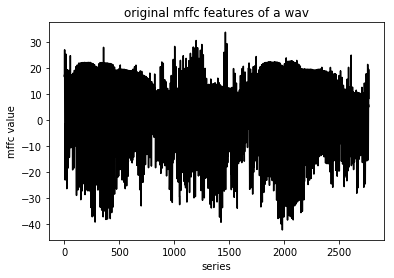

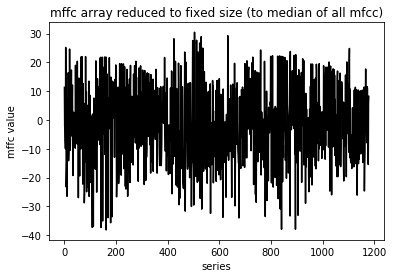

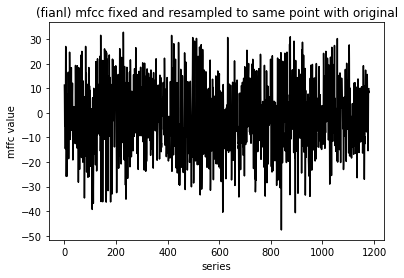

In [387]:
plt.plot(x_values, test_data[0][:], color='black')
plt.xlabel('series')
plt.ylabel('mffc value')
plt.title('original mffc features of a wav')
plt.show()

plt.plot(x, y, color='black')
plt.xlabel('series')
plt.ylabel('mffc value')
plt.title('mffc array reduced to fixed size (to median of all mfcc)')
plt.show()


plt.plot(xnew, f, color='black')
plt.xlabel('series')
plt.ylabel('mffc value')
plt.title('(fianl) mfcc fixed and resampled to same point with original')
plt.show()

In [358]:
f.shape

(494,)

In [374]:
count=0
for i,_ in enumerate(data):
    if data[i].shape[1]<800:
        test_data=data[i]
        count+=1
count

4499

In [372]:
def replicate_up(test_data):
    a=np.zeros(median_mfcc)
    a[:]=np.nan
    a[0:test_data.shape[1]]=test_data
    
    # replicate 
    n=len(a)
    p=n-np.isnan(a).sum() # count of valids assuming nan's at the end.
    repeats=n//p
    m=n-repeats*p # number of overfilled.
    q=m*(repeats+1) #border
    a[q:]=a[m:p].repeat(repeats) #the end
    a[:q]=a[:m].repeat(repeats+1) #the beginning
    
    return np.array([a])

In [366]:
a=np.zeros(median_mfcc)
a[:]=np.nan
a[0:test_data.shape[1]]=test_data

In [367]:
n=len(a)
p=n-np.isnan(a).sum() # count of valids assuming nan's at the end.
repeats=n//p
m=n-repeats*p # number of overfilled.
q=m*(repeats+1) #border
a[q:]=a[m:p].repeat(repeats) #the end
a[:q]=a[:m].repeat(repeats+1) #the beginning
new_test_data=np.array([a])

In [375]:
v=replicate_up(test_data)

In [380]:
v.shape

(1, 1180)

In [350]:
xnew=np.linspace(0, median_mfcc, median_mfcc, endpoint=False)
ynew=new_test_data[0][:]
x_real=np.linspace(0, test_data.shape[1], test_data.shape[1], endpoint=False)
y_real=test_data[0][:]

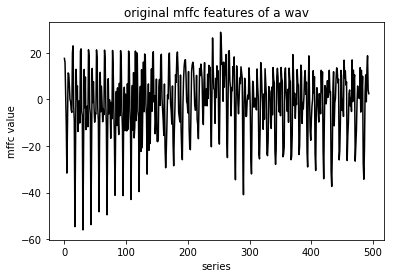

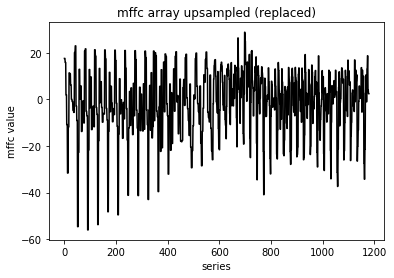

In [351]:
plt.plot(x_real, y_real, color='black')
plt.xlabel('series')
plt.ylabel('mffc value')
plt.title('original mffc features of a wav')
plt.show()

plt.plot(xnew, ynew, color='black')
plt.xlabel('series')
plt.ylabel('mffc value')
plt.title('mffc array upsampled (replaced)')
plt.show()


#### Get Labels

In [4]:
label_idx_dic={} # dict for storing labels

#Each sample file is one row in data, and has one entry in labels
print('Number of files total:', len(data))
all_labels = np.zeros(len(data),dtype=int)
for n, l in enumerate(set(labels)):
    label_idx_dic[n]=l
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n
print('Labels and label indices', all_labels)

Number of files total: 21433
Labels and label indices [16 16 16 ... 33 33 33]


In [16]:
# save label dictionary
def save_dict_to_file(dic):
    f = open('dict.txt','w')
    f.write(str(dic))
    f.close()

# load label dictionary
def load_dict_from_file():
    f = open('dict.txt','r')
    data=f.read()
    f.close()
    return eval(data)

# save dict
save_dict_to_file(label_idx_dic)

# read dict
label_idx_dic = load_dict_from_file()

In [17]:
print(label_idx_dic)

{0: 'decimal',
 1: 'Seats & Belts',
 2: '8_eight',
 3: 'locked',
 4: 'Cabin doors',
 5: '6_six',
 6: 'Shut-off cabin heat',
 7: 'Closed',
 8: 'Checked',
 9: '0_zero',
 10: 'in',
 11: 'Completed',
 12: '2_two',
 13: '3_three',
 14: '5_five',
 15: '7_seven',
 16: 'Fuel Shutoff Valve',
 17: 'Fuel Temperature',
 18: 'preflight_inspection',
 19: '1_one',
 20: 'sufficient',
 21: 'off',
 22: 'Cockpit',
 23: 'On',
 24: '4_four',
 25: 'Battery+Main bus',
 26: 'Weight and balance',
 27: 'Flight Controls',
 28: '9_nine',
 29: 'Fuel Quantity',
 30: 'Fuel Selector',
 31: 'Cockpit checklist completed',
 32: 'aboard',
 33: 'open',
 34: 'removed',
 35: 'adjusted & locked',
 36: 'Circuit Breakers',
 37: 'All switches',
 38: 'Alternate air door',
 39: 'A_C Documents',
 40: 'Towbar'}

#### Pad Zeros to Small Arrays

In [9]:
x_data = np.zeros((len(data),mfcc_max_length+1), dtype=float)

for i,_d in enumerate(data):
    x_data[i,1:_d.shape[1]+1]=_d
    x_data[i,0]=all_labels[i]

In [11]:
# save all features data
np.savetxt('data.csv', x_data, delimiter=',')

In [7]:
labels=['{}: {}'.format(i,i) for i in range(5)]
labels

['0: 0', '1: 1', '2: 2', '3: 3', '4: 4']

In [21]:
labels=['{}: {}'.format(4,4),'{}: {}'.format(4,4)]

In [22]:
labels

['4: 4', '4: 4']